In [5]:
import os
import sys
from tqdm.auto import tqdm


PROJECT_DIR="/mnt/workspace/__ing/cving/brain-tumor-detection"
sys.path.append(PROJECT_DIR)
cache_dir = os.path.join(
    PROJECT_DIR,
    "hf_cache"
)
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HF_HOME'] = cache_dir


import utils.torch
from utils.validation import create_confusion_matrix, plot_confusion_matrix

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor
from transformers import ViTForImageClassification, Trainer, TrainingArguments
from utils.image import (CLASS_2_ID_DICT, ID_2_CLASS_DICT,
                         PREFIX_2_CLASS_DICT)

# Data

In [2]:
# Feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Create dataset instances
data_dir = os.path.join(
    PROJECT_DIR,
    "data/Training",
)
full_dataset = utils.torch.CustomDataset(
    root_dir=data_dir, feature_extractor=feature_extractor
)

# Split the dataset into training and validation
train_dataset, val_dataset = full_dataset.train_val_split(train_perc=0.8, seed=42)

/home/mohammed/anaconda3/envs/vit-env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# Model

In [15]:
train_more = True

In [16]:
finetuned_model_dir = os.path.join(
    PROJECT_DIR,
    "models/vit/results",
    "finetuned_vit_model",
)

if os.path.exists(finetuned_model_dir) and not train_more:
    model = ViTForImageClassification.from_pretrained(finetuned_model_dir)
else:
    if os.path.exists(finetuned_model_dir):
        model = ViTForImageClassification.from_pretrained(finetuned_model_dir)
    else:
        model = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224-in21k', num_labels=len(CLASS_2_ID_DICT)
        )

    # Define the training arguments
    training_args = TrainingArguments(
        output_dir=os.path.join(
            PROJECT_DIR,
            "models/vit/results",
        ),
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir=os.path.join(
            PROJECT_DIR,
            "models/vit/logs",
        ),
        load_best_model_at_end=True,
    )

    # Define the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=feature_extractor,
    )

    # Train the model
    trainer.train()
    trainer.save_model(finetuned_model_dir)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mohammed/anaconda3/envs/vit-env/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.300600,0.104913
2,0.054600,0.099726
3,0.028200,0.075987
4,0.012000,0.087611
5,0.004700,0.061972


In [17]:
val_misclassified_images = utils.torch.get_misclassified_images(
    model, 
    DataLoader(val_dataset, batch_size=64, shuffle=False), 
    device="cuda"
)

  0%|          | 0/18 [00:00<?, ?it/s]

In [18]:
train_misclassified_images = utils.torch.get_misclassified_images(
    model, 
    DataLoader(train_dataset, batch_size=64, shuffle=False), 
    device="cuda"
)

  0%|          | 0/72 [00:00<?, ?it/s]

In [19]:
train_counts = utils.torch.get_dataset_counts(train_dataset)
val_counts = utils.torch.get_dataset_counts(val_dataset)

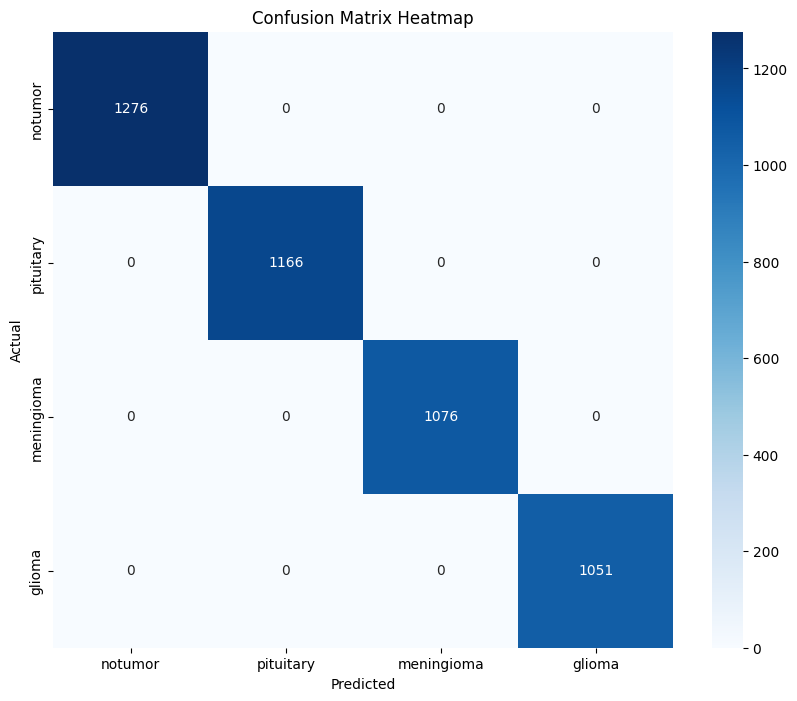

In [20]:
train_confusion_matrix = create_confusion_matrix(train_misclassified_images, train_counts)
plot_confusion_matrix(train_confusion_matrix)

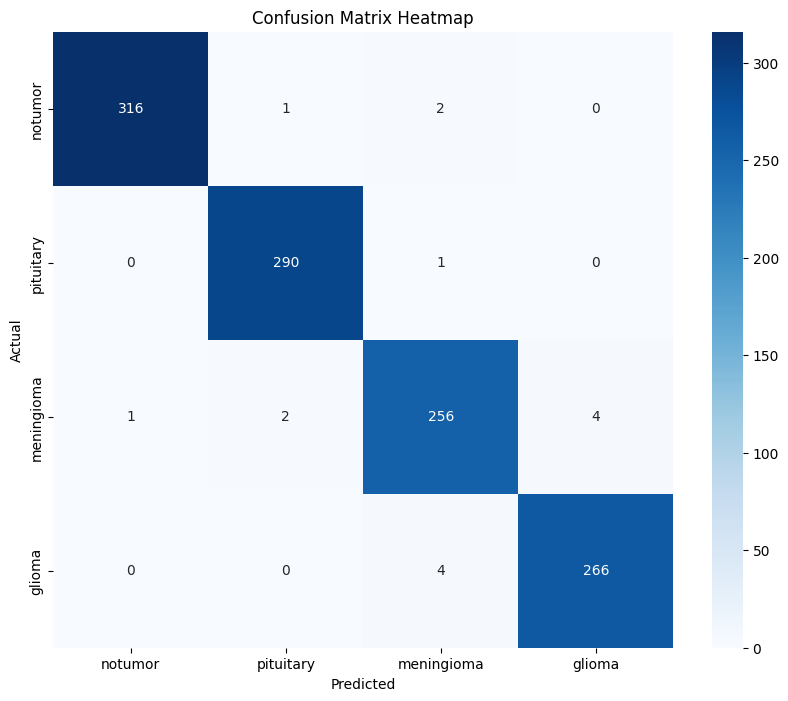

In [21]:
val_confusion_matrix = create_confusion_matrix(val_misclassified_images, val_counts)
plot_confusion_matrix(val_confusion_matrix)